# REGALS analysis of NrdE AEX data

The data and analysis were published in:

**An endogenous dAMP ligand in Bacillus subtilis class Ib RNR promotes assembly of a noncanonical dimer for regulation by dATP**

Mackenzie J. Parker, Ailiena O. Maggiolo, William C. Thomas, Albert Kim, Steve P. Meisburger, Nozomi Ando, Amie K. Boal, JoAnne Stubbe

PNAS, May 2018, 115 (20), E4594-E4603; DOI: 10.1073/pnas.1800356115


In [1]:
%matplotlib inline

import sys
import os
sys.path.append(os.path.abspath('../python/'))

import h5py
import numpy as np

from regals import *

import matplotlib.pyplot as plt

## Load data

In [2]:
NrdE_mix_AEX = {}
with h5py.File('data/NrdE_mix_AEX.mat', 'r') as f:
    for key in f:
        NrdE_mix_AEX[key] = np.array(f[key])

#Store raw data
q = NrdE_mix_AEX['q'][0]
I = NrdE_mix_AEX['I'].T
sigma = NrdE_mix_AEX['sigma'].T
x = np.arange(I.shape[1])

## Set up REGALS calculation
Each component has a peak and profile regularizer. In thise case, there is no regularization of the profiles (all are "simple" type).

In [3]:
Bg1 = component(peak_class('smooth',x, xmin = np.amin(x)-1E-3, xmax = np.amax(x)+1E-3, is_zero_at_xmin = False, is_zero_at_xmax = False),\
                profile_class('simple',q))

Bg2 = component(peak_class('smooth',x, xmin = 201-1E-3, xmax = np.amax(x)+1E-3, is_zero_at_xmin = True, is_zero_at_xmax = False),\
                profile_class('simple',q))

C1 = component(peak_class('smooth',x, xmin = 730, xmax = 1270),\
               profile_class('simple',q))

C2 = component(peak_class('smooth',x, xmin = 1150, xmax = 1600),\
               profile_class('simple',q))

# create Mixture object and set regularization parameters
M = mixture([C1,C2,Bg1,Bg2])
M.lambda_peak = M.estimate_peak_lambda(sigma,np.array([np.inf,np.inf,8,8]))

## Run REGALS

In [4]:
# creat REGALS object
R = regals(I,sigma);

# set stopFun to return true when 50 iterations is exceeded
stop_fun = lambda num_iter, params: [num_iter >= 50, 'max_iter']

update_fun = lambda num_iter, mix, params,resid: \
    print('%2d, x2 = %f, delta_profile = %s'%(num_iter,params['x2'],np.array2string(params['delta_profile'],precision=3)))

# run for 50 iterations
[M1,params,resid,exit_cond] = R.run(M, stop_fun, update_fun);

# extract the two particle components (no regularization)
[I1,sigma1] = M1.extract_profile(I,sigma,0);
[I2,sigma2] = M1.extract_profile(I,sigma,1);

 1, x2 = 1.168476, delta_profile = [389.705 455.882 290.414  71.728]
 2, x2 = 1.040155, delta_profile = [ 44.318 116.791 283.765  65.681]
 3, x2 = 1.023741, delta_profile = [ 2.203  1.458 47.403 37.933]
 4, x2 = 1.017005, delta_profile = [ 1.816  0.362 21.091  5.19 ]
 5, x2 = 1.014639, delta_profile = [0.823 0.18  8.943 2.175]
 6, x2 = 1.013693, delta_profile = [0.555 0.119 4.645 0.717]
 7, x2 = 1.013257, delta_profile = [0.404 0.08  2.231 0.891]
 8, x2 = 1.013023, delta_profile = [0.307 0.053 0.979 1.267]
 9, x2 = 1.012877, delta_profile = [0.236 0.036 0.348 1.521]
10, x2 = 1.012773, delta_profile = [0.182 0.025 0.072 1.658]
11, x2 = 1.012691, delta_profile = [0.141 0.017 0.118 1.727]
12, x2 = 1.012620, delta_profile = [0.109 0.012 0.18  1.757]
13, x2 = 1.012556, delta_profile = [0.085 0.009 0.207 1.768]
14, x2 = 1.012496, delta_profile = [0.067 0.007 0.216 1.768]
15, x2 = 1.012439, delta_profile = [0.053 0.006 0.216 1.763]
16, x2 = 1.012384, delta_profile = [0.042 0.005 0.212 1.756]


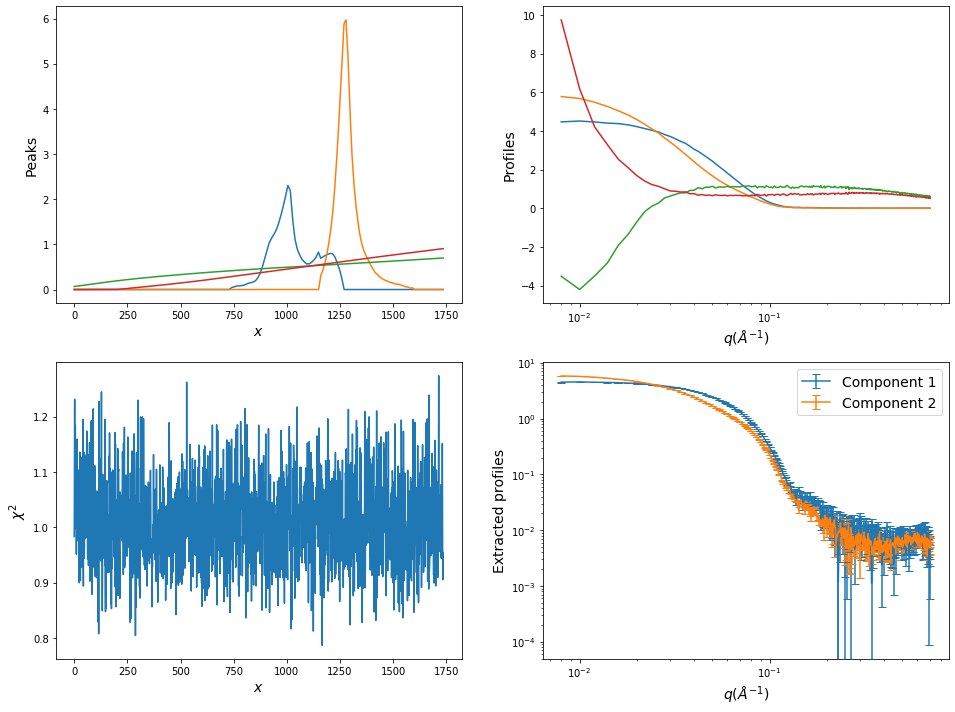

In [5]:
# plot the end results
plt.rcParams['figure.figsize'] = 16, 12
fig, axs = plt.subplots(2, 2)

#peaks vs x
axs[0, 0].plot(x, M1.peaks)
axs[0, 0].set_xlabel('$x$', fontsize=14)
axs[0, 0].set_ylabel('Peaks', fontsize=14)

#chi2 vs x
axs[1, 0].plot(x, np.mean(resid ** 2, 0))
axs[1, 0].set_xlabel('$x$', fontsize=14)
axs[1, 0].set_ylabel('$\chi^2$', fontsize=14)

#profiles vs q
axs[0, 1].semilogx(q, M1.profiles)
axs[0, 1].set_xlabel('$q (Å^{-1})$', fontsize=14)
axs[0, 1].set_ylabel('Profiles', fontsize=14)

#extracted profiles
axs[1, 1].errorbar(q, I1, sigma1, capsize=4, label='Component 1')
axs[1, 1].errorbar(q, I2, sigma2, capsize=4, label='Component 2')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('$q (Å^{-1})$', fontsize=14)
axs[1, 1].set_ylabel('Extracted profiles', fontsize=14)
plt.legend(fontsize=14)

plt.show()